In [282]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as pltimg
%matplotlib inline

training_data_dir = './training_model_data/'
training_good_s = os.path.join(training_data_dir, 'good_soles')
training_bad_s = os.path.join(training_data_dir, 'bad_soles')

print('Training good soles: ', len(os.listdir(training_good_s)))
print('Training bad soles: ', len(os.listdir(training_bad_s)))

testing_data_dir = './test_model_data/'
testing_good_s = os.path.join(testing_data_dir, 'good_soles')
testing_bad_s = os.path.join(testing_data_dir, 'bad_soles')

print('Testing good soles: ', len(os.listdir(testing_good_s)))
print('Testing bad soles: ', len(os.listdir(testing_bad_s)))

Training good soles:  109
Training bad soles:  84
Testing good soles:  22
Testing bad soles:  20


In [283]:
from tensorflow import keras
from keras import layers
from keras import Model

In [284]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [285]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adam

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
#x = layers.Convolution2D(64, 3, activation='relu')(x)
#x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001), #RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [286]:
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_64 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 41472)             0  

In [287]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,    
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.47,
    shear_range=0.4,
    zoom_range=0.27,
    horizontal_flip=True,
    preprocessing_function=random_invert)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        training_data_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 193 images belonging to 2 classes.


In [288]:
val_datagen = ImageDataGenerator(rescale=1./255)
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        testing_data_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 42 images belonging to 2 classes.


In [289]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,  # 159 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=2,  # 63 images = batch_size * steps
      verbose=2,
      shuffle=True)

Epoch 1/20
10/10 - 8s - loss: 1.0591 - acc: 0.4508 - val_loss: 0.7122 - val_acc: 0.4500 - 8s/epoch - 789ms/step
Epoch 2/20
10/10 - 7s - loss: 0.7092 - acc: 0.5285 - val_loss: 0.7055 - val_acc: 0.5000 - 7s/epoch - 707ms/step
Epoch 3/20
10/10 - 7s - loss: 0.6841 - acc: 0.5648 - val_loss: 0.8318 - val_acc: 0.5250 - 7s/epoch - 709ms/step
Epoch 4/20
10/10 - 7s - loss: 0.7020 - acc: 0.5648 - val_loss: 0.6974 - val_acc: 0.4750 - 7s/epoch - 710ms/step
Epoch 5/20
10/10 - 7s - loss: 0.6815 - acc: 0.5596 - val_loss: 0.6955 - val_acc: 0.4750 - 7s/epoch - 697ms/step
Epoch 6/20
10/10 - 7s - loss: 0.6892 - acc: 0.5596 - val_loss: 0.6903 - val_acc: 0.5250 - 7s/epoch - 694ms/step
Epoch 7/20
10/10 - 7s - loss: 0.6776 - acc: 0.5648 - val_loss: 0.6867 - val_acc: 0.5500 - 7s/epoch - 709ms/step
Epoch 8/20
10/10 - 7s - loss: 0.6805 - acc: 0.5648 - val_loss: 0.6911 - val_acc: 0.5000 - 7s/epoch - 690ms/step
Epoch 9/20
10/10 - 7s - loss: 0.6749 - acc: 0.5648 - val_loss: 0.6818 - val_acc: 0.5250 - 7s/epoch - 705

Text(0.5, 1.0, 'Training and validation loss')

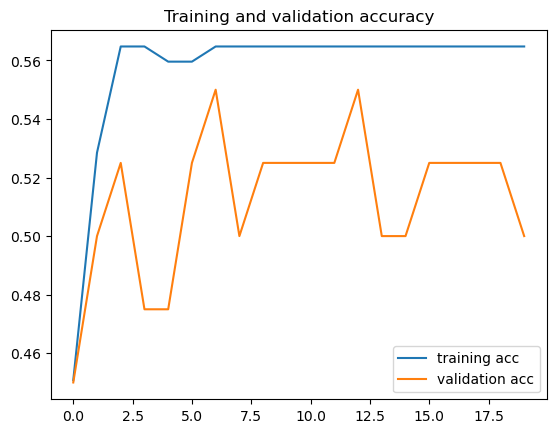

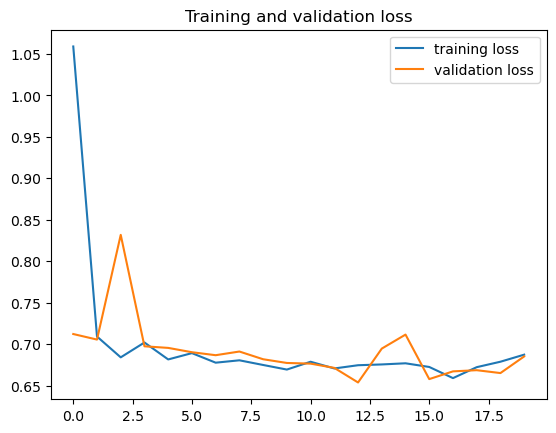

In [321]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

In [323]:
predict = model.predict(validation_generator)
predicted_classes = np.argmax(predict, axis=1)

3/3 [==============================] - 1s 357ms/step


NameError: name 'np' is not defined

In [309]:
test_sample_dir = './test_sample/'
test_sample_gen = ImageDataGenerator(rescale=1./255)
test_sample = test_sample_gen.flow_from_directory(test_sample_dir, target_size=(150, 150))

Found 0 images belonging to 0 classes.


In [311]:
model.evaluate(test_sample_dir)

IndexError: tuple index out of range

In [313]:
def predict(model, img_path):
    img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = keras.preprocessing.image.img_to_array(img)
    prediction = model.predict(tf.expand_dims(img_array, axis=0))

    return prediction.flatten().tolist()[0]

In [316]:
predict(model, './test_sample/test-prediction-new.jpg')

1/1 [==============================] - 0s 15ms/step


1.0

In [317]:
predict(model, './test_sample/test-pred-mid.png')

1/1 [==============================] - 0s 15ms/step


1.0

In [318]:
predict(model, './test_sample/test-pred-bad.png')

1/1 [==============================] - 0s 15ms/step


0.9999998211860657

In [322]:
predict(model, './test_sample/kg-needmaintenance-s2.jpeg')

1/1 [==============================] - 0s 16ms/step


0.99951171875